In [2]:
import pandas as pd
import numpy as np

import os.path

# Preprocessing import statements
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# SVM model building imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Random Forrest model imports
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Logistic Regression Imports
from sklearn.linear_model import LogisticRegression
import athena # Custom Logistic Regression Model built using Gradient Descent

# KMeans imports
from sklearn.cluster import KMeans

# Accuracy score
from sklearn.metrics import accuracy_score

#Visualization imports
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from pprint import pprint


### Data Preprocessing

In [3]:
data_file = os.path.join("data","cleaned_data.xlsx")

# Reads in the data for temperature and the labels
temperature_2m_mean_df = pd.read_excel(data_file, sheet_name = "temperature_2m_mean", index_col = 0)
y = temperature_2m_mean_df["Status"] == "Vintage"
temperature_2m_mean_X = temperature_2m_mean_df.drop("Status", axis = 1)

In [4]:
# Reads in the data for precipitation...fill any empty cell values with 0 
precipitation_sum_df = pd.read_excel(data_file, sheet_name = "precipitation_sum", index_col = 0)
precipitation_sum_X = precipitation_sum_df.drop("Status", axis = 1).fillna(0)

In [5]:
#Reads in the data for shortwave radiation...fill any empty cells with the average for that day over the years
shortwave_radiation_df = pd.read_excel(data_file, sheet_name = "shortwave_radiation", index_col = 0)
shortwave_radiation_X = shortwave_radiation_df.drop("Status", axis = 1)
shortwave_radiation_X.fillna(shortwave_radiation_X.mean(axis = 0), inplace = True)

### Dimensional Reduction

In [6]:
dim_reducer = LinearDiscriminantAnalysis(solver = "svd", n_components = 1)
dim_reducer.fit(temperature_2m_mean_X, y)
temp_red_X = dim_reducer.transform(temperature_2m_mean_X)

dim_reducer.fit(precipitation_sum_X, y)
precip_red_X = dim_reducer.transform(precipitation_sum_X)

dim_reducer.fit(shortwave_radiation_X, y)
radiation_red_X = dim_reducer.transform(shortwave_radiation_X)

X_raw = np.concatenate([temp_red_X, precip_red_X, radiation_red_X], axis = 1)
X = pd.DataFrame(X_raw, columns = ["Temperature Reduced", "Precipitation Reduced", "Radiation Reduced"], index = range(1940, 2024))

X_model = X.iloc[0:74]
X_predict = X.iloc[75:]

y_model = y.iloc[0:74]

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size = 0.2, random_state = 13)

# Supervised Learning

### Support Vector Machines (SVM)

In [7]:
model1 = make_pipeline(StandardScaler(), SVC(gamma = "auto"))
model1.fit(X_train, y_train)

print(f"Support Vector Machines Model Accuracy: {round(model1.score(X_test, y_test) * 100, 3)}%")
print(model1.predict(X_predict))


Support Vector Machines Model Accuracy: 86.667%
[False  True False  True False  True False False False]


### Random Forest

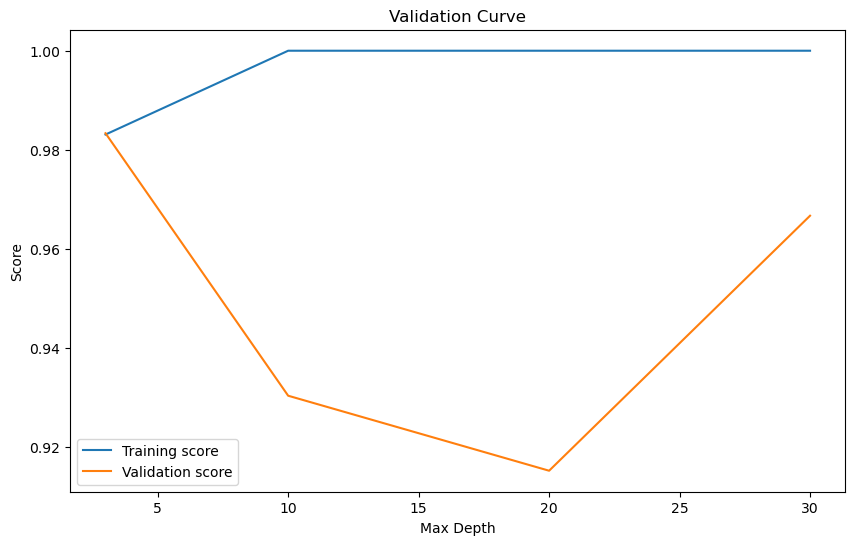

In [51]:
# Define range of max_depth values
max_depth_range = [3, 10, 20, 30]

rf = RandomForestClassifier()

# Compute validation curve
train_scores, test_scores = validation_curve(rf, X_train, y_train, param_name="max_depth", param_range=max_depth_range, cv=5)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(max_depth_range, np.mean(test_scores, axis=1), label='Validation score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Validation Curve')
plt.legend()
plt.show()

In [8]:
model2 = RandomForestClassifier(max_depth = 3, random_state = 13)
model2.fit(X_train, y_train)

print(f"Random Forest Classifier Model Accuracy: {round(model2.score(X_test, y_test) * 100, 3)}%")
print(model2.predict(X_predict))

Random Forest Classifier Model Accuracy: 80.0%
[False  True False  True False  True False False False]


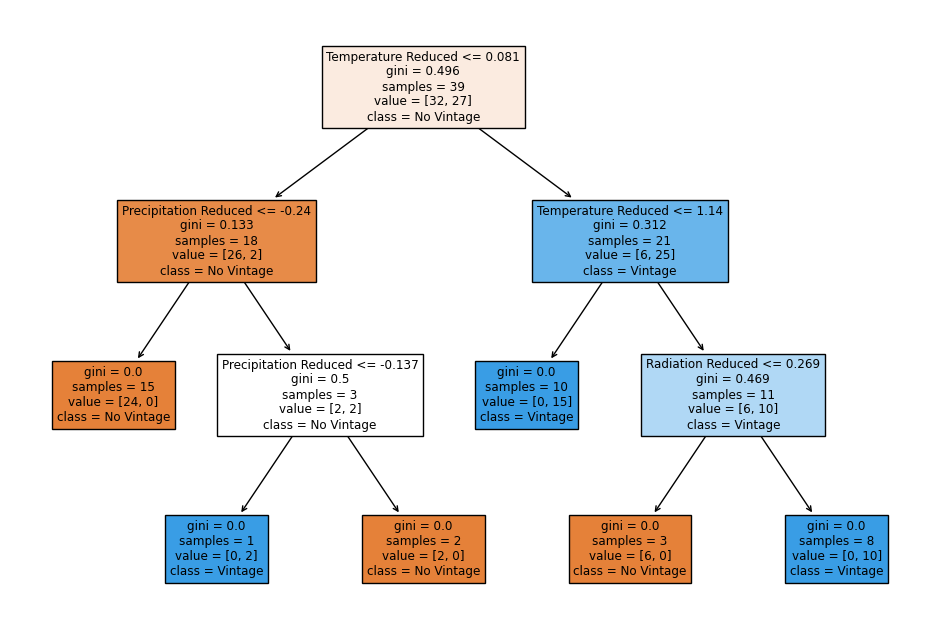

In [53]:
plt.figure(figsize=(12, 8))
plot_tree(model2.estimators_[0], feature_names=list(X_train.columns), class_names = ["No Vintage", "Vintage"],  filled=True)
plt.show()

In [9]:
model2a = DecisionTreeClassifier(criterion = "entropy", splitter = "best", max_depth = 3)
model2a.fit(X_train, y_train)

print(f"Specialized Decision Tree Model Accuracy: {round(model2a.score(X_test, y_test) * 100, 3)}%")
print(model2a.predict(X_predict))



Specialized Decision Tree Model Accuracy: 86.667%
[False  True False  True  True  True False False  True]


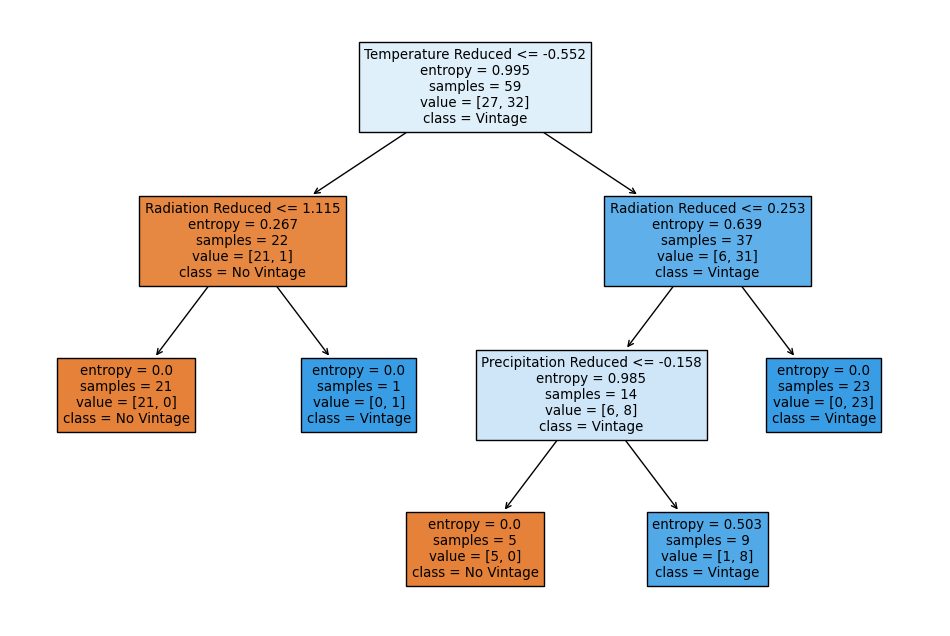

In [55]:
plt.figure(figsize=(12, 8))
plot_tree(model2a, feature_names=list(X_train.columns), class_names = ["No Vintage", "Vintage"],  filled=True)
plt.show()

### Logistic Regression

In [10]:
model3 = LogisticRegression(random_state = 13, solver = "liblinear")
model3.fit(X_train, y_train)

print(f"SKLearn Logistic Regression Model Accuracy: {round(model3.score(X_test, y_test) * 100, 3)}%")
print(model3.predict(X_predict))

coef3 = model3.coef_
intercept3 = model3.intercept_

SKLearn Logistic Regression Model Accuracy: 93.333%
[False  True False False False  True False False False]


In [11]:
X_train_3a, y_train_3a, X_test_3a, y_test_3a = X_train.to_numpy(), y_train.to_numpy().astype(int), X_test.to_numpy(), y_test.to_numpy().astype(int)

model3a = athena.LogisticRegression()
theta = model3a.fit(X_train_3a, y_train_3a, X_test_3a, y_test_3a, .01, 10000)

Epoch 0:
	train loss: 0.689	train acc: 29.797
	val loss:   0.689	val acc:   7.6
Epoch 1000:
	train loss: 0.271	train acc: 29.797
	val loss:   0.227	val acc:   7.6
Epoch 2000:
	train loss: 0.258	train acc: 29.797
	val loss:   0.199	val acc:   7.6
Epoch 3000:
	train loss: 0.256	train acc: 29.797
	val loss:   0.189	val acc:   7.6
Epoch 4000:
	train loss: 0.255	train acc: 29.797
	val loss:   0.184	val acc:   7.6
Epoch 5000:
	train loss: 0.254	train acc: 29.797
	val loss:   0.182	val acc:   7.6
Epoch 6000:
	train loss: 0.254	train acc: 29.797
	val loss:   0.18	val acc:   7.6
Epoch 7000:
	train loss: 0.254	train acc: 29.797
	val loss:   0.179	val acc:   7.6
Epoch 8000:
	train loss: 0.254	train acc: 29.797
	val loss:   0.179	val acc:   7.6
Epoch 9000:
	train loss: 0.254	train acc: 29.797
	val loss:   0.179	val acc:   7.6


In [12]:
X_pred_train = np.concatenate([np.ones((X_train_3a.shape[0], 1)), X_train_3a], axis = 1)
pp_train = model3a.predict_probs(X_pred_train, theta)
y_pred_train = model3a.predict_labels(pp_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

X_pred_test = np.concatenate([np.ones((X_test_3a.shape[0], 1)), X_test_3a], axis = 1)
pp_test = model3a.predict_probs(X_pred_test, theta)
y_pred_test = model3a.predict_labels(pp_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Logistic Regression with Gradient Descent Training Accuracy: {round(train_accuracy * 100, 3)}%")
print(f"Logistic Regression with Gradient Descent Testing Accuracy: {round(test_accuracy * 100, 3)}%")

Logistic Regression with Gradient Descent Training Accuracy: 91.525%
Logistic Regression with Gradient Descent Testing Accuracy: 93.333%


In [13]:
X_predict_3a = X_predict.to_numpy()
X_predict_3a = np.concatenate([np.ones((X_predict_3a.shape[0], 1)), X_predict_3a], axis = 1)
pp_predict = model3a.predict_probs(X_predict_3a, theta)
y_predict = model3a.predict_labels(pp_predict)
y_predict.astype(bool).T


array([[False,  True, False, False, False,  True, False, False, False]])

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_train["Temperature Reduced"],
    y=X_train["Precipitation Reduced"],
    z=X_train["Radiation Reduced"],
    mode='markers',
    marker=dict(
        color=y_train.astype(int),
        size=5
    ),
    name='Data Points'
))



x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
x, y = np.meshgrid(x, y)
z = (-intercept3[0] - coef3[0][0]*x - coef3[0][1]*y) / coef3[0][2]

fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.7))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='X3')
    ),
    title='SKLearn Logistic Regression Graph'
)

# Show plot
fig.show()

In [61]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_train["Temperature Reduced"],
    y=X_train["Precipitation Reduced"],
    z=X_train["Radiation Reduced"],
    mode='markers',
    marker=dict(
        color=y_train.astype(int),
        size=5
    ),
    name='Data Points'
))



x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
x, y = np.meshgrid(x, y)
z = (-theta[0] - theta[1]*x - theta[2]*y) / theta[3]

fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.7))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='X3')
    ),
    title='Logistic Regression with Gradient Descent Graph'
)

# Show plot
fig.show()

# Unsupervised Learning

### K-Means

In [62]:
model4 = KMeans(n_clusters = 2, n_init = "auto", random_state = 13) 
model4.fit(X_train)

y_pred = model4.labels_

accuracy_score(y_train, y_pred)

0.1016949152542373